In [34]:
path_main_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"
path_crossct_summarized_table = "../results/2023-05-24/00_processed/crossCT/aurocs.tsv.gz"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./cross_celltypes/"
export = True


# Forewords

Cross cell type application of models

# Imports


In [20]:
import copy
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [21]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

## Data

In [22]:
full_summary_table = pd.read_csv(
    path_main_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

In [23]:
full_summary_table_ct = pd.read_csv(
    path_crossct_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

full_summary_table_ct["RBP-name"] = (
    full_summary_table_ct["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 0]
    .values
)
full_summary_table_ct["CT"] = (
    full_summary_table_ct["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 1]
    .values
)

In [24]:
full_summary_table_ct['RBP_dataset'].unique().shape

(146,)

## Config

In [25]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


# Prepare datasets

## Cross-evaluations

In [26]:
t1_ct_n1 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "K562") & (df["model_negativeset"] == "negative-1"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t1_ct_n2 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "K562") & (df["model_negativeset"] == "negative-2"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_ct_n1 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "HepG2") & (df["model_negativeset"] == "negative-1"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_ct_n2 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "HepG2") & (df["model_negativeset"] == "negative-2"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)


In [27]:
cross_ct_merged_n1 = pd.merge(
    t1_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


cross_ct_merged_n2 = pd.merge(
    t1_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


## Self evaluations

In [28]:
tmp = full_summary_table.loc[
    lambda df: (df["dataset"] == "ENCODE")
    & (df["arch"].isin(full_summary_table_ct["arch"].unique()))
    & (
        df["RBP_dataset"].isin(cross_ct_merged_n1["RBP_dataset.K562"].values)
        | df["RBP_dataset"].isin(cross_ct_merged_n1["RBP_dataset.HepG2"])
    ),
    :,
].copy()
tmp["RBP-name"] = tmp["RBP_dataset"].str.split("_", expand=True).iloc[:, 0].values
tmp["CT"] = tmp["RBP_dataset"].str.split("_", expand=True).iloc[:, 1].values


In [29]:
t1_o_n1 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("K562"))
        & (df["model_negativeset"] == "negative-1"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t1_o_n2 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("K562"))
        & (df["model_negativeset"] == "negative-2"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_o_n1 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("HepG2"))
        & (df["model_negativeset"] == "negative-1"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_o_n2 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("HepG2"))
        & (df["model_negativeset"] == "negative-2"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)


In [30]:
cross_o_merged_n1 = pd.merge(
    t1_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


cross_o_merged_n2 = pd.merge(
    t1_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


## Self vs cross

In [31]:
k562_selfcross_merged_n1 = pd.merge(
    t1_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t1_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()

k562_selfcross_merged_n2 = pd.merge(
    t1_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t1_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


hepg2_selfcross_merged_n1 = pd.merge(
    t2_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t2_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


hepg2_selfcross_merged_n2 = pd.merge(
    t2_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t2_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


## Relative drop in performance

In [32]:
def calculate_relative_drop_auroc(selfcross_df: pd.DataFrame) -> pd.Series:
    return (selfcross_df["auroc.cross"] - selfcross_df["auroc.self"]) / selfcross_df[
        "auroc.self"
    ]


k562_selfcross_merged_n1["auroc.reldrop"] = calculate_relative_drop_auroc(
    k562_selfcross_merged_n1
)
k562_selfcross_merged_n2["auroc.reldrop"] = calculate_relative_drop_auroc(
    k562_selfcross_merged_n2
)
hepg2_selfcross_merged_n1["auroc.reldrop"] = calculate_relative_drop_auroc(
    hepg2_selfcross_merged_n1
)
hepg2_selfcross_merged_n2["auroc.reldrop"] = calculate_relative_drop_auroc(
    hepg2_selfcross_merged_n2
)


# Scatterplots

## Same CT performances (K562 vs HepG2)

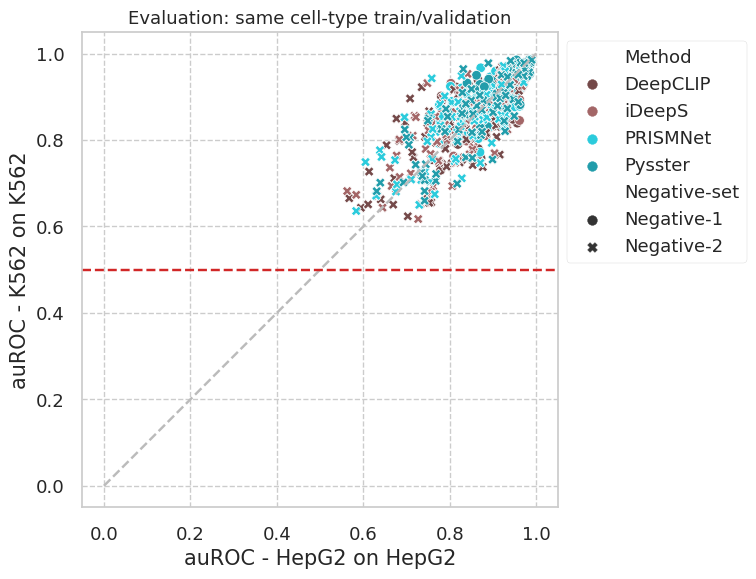

In [38]:
panel_name = "ij"

figure_name = "self_ct_aurocs.K562_vs_HepG2"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            cross_o_merged_n1.assign(negativeset="Negative-1"),
            cross_o_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.HepG2",
    y="auroc.K562",
    hue="Method",
    style="Negative-set",
    palette=arch_colors,
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.,1.05])
# ax1.set_ylim([0.,1.05])

ax1.set_xlabel("auROC - HepG2 on HepG2")
ax1.set_ylabel("auROC - K562 on K562")

ax1.set_title("Evaluation: same cell-type train/validation")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    my_savefig(savefig_file)

plt.tight_layout()


plt.show()


## Cross CT performances (K562 vs HepG2)

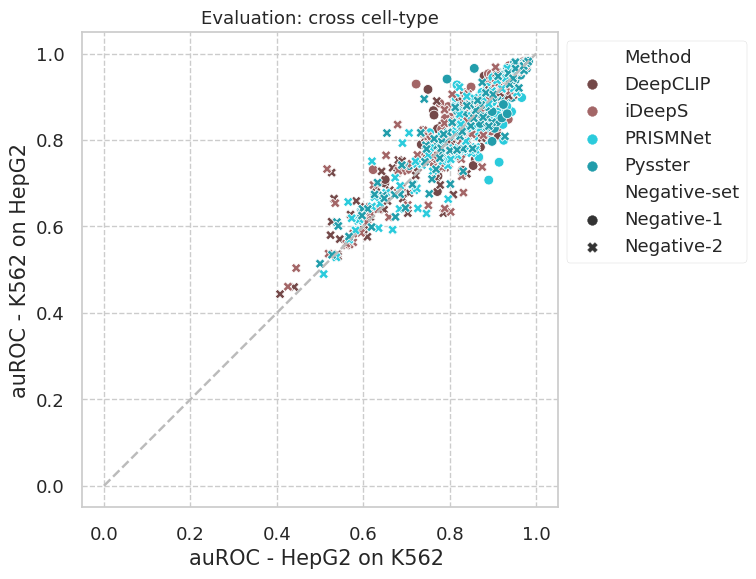

In [42]:
panel_name = "i"

figure_name = "cross_ct_aurocs.K562_vs_HepG2"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES[panel_name]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            cross_ct_merged_n1.assign(negativeset="Negative-1"),
            cross_ct_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.HepG2",
    y="auroc.K562",
    hue="Method",
    style="Negative-set",
    palette=arch_colors,
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")

ax1.set_aspect("equal")

ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])

ax1.set_xlabel("auROC - HepG2 on K562 ")
ax1.set_ylabel("auROC - K562 on HepG2")

ax1.set_title("Evaluation: cross cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file)

plt.show()


## Same CT vs cross CT

### K562 on HepG2

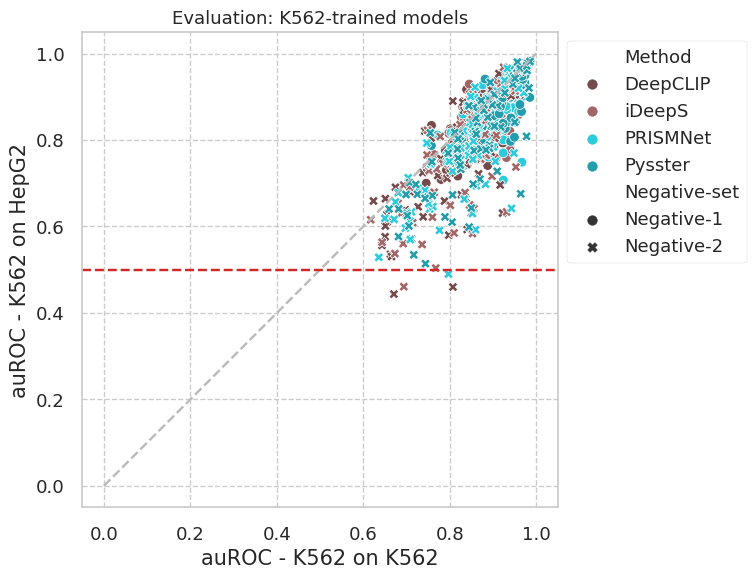

In [43]:

panel_name = "i"


figure_name = "self_vs_cross_ct_aurocs.K562"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            k562_selfcross_merged_n1.assign(negativeset="Negative-1"),
            k562_selfcross_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.self",
    y="auroc.cross",
    hue="Method",
    palette=arch_colors,
    style="Negative-set",
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel("auROC - K562 on K562")
ax1.set_ylabel("auROC - K562 on HepG2")

ax1.set_title("Evaluation: K562-trained models")


# ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file)


plt.show()


### HepG2 on K562

Saving


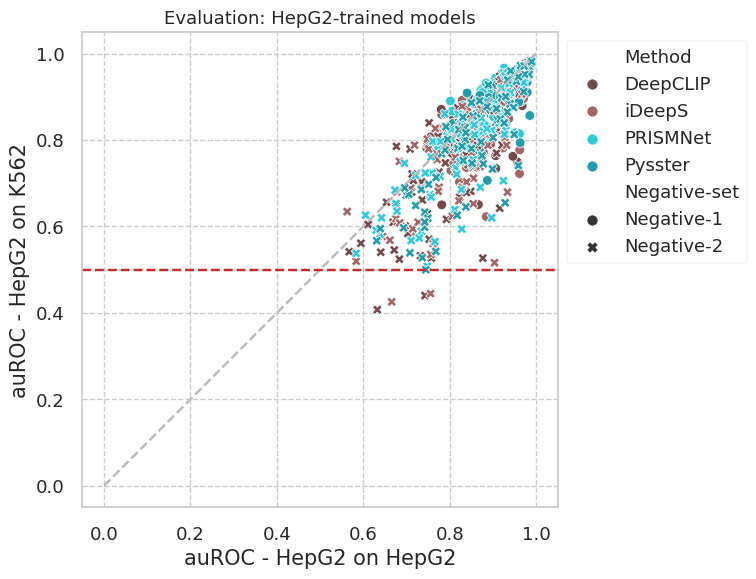

In [48]:
panel_name = "j"

figure_name = "self_vs_cross_ct_aurocs.HepG2"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            hepg2_selfcross_merged_n1.assign(negativeset="Negative-1"),
            hepg2_selfcross_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.self",
    y="auroc.cross",
    hue="Method",
    palette=arch_colors,
    style="Negative-set",
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel("auROC - HepG2 on HepG2")
ax1.set_ylabel("auROC - HepG2 on K562")

ax1.set_title("Evaluation: HepG2-trained models")


# ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)
plt.tight_layout()


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)


plt.show()


# Relative drop in performance

Description: 

- for a given model, compute the percentage drop in auROC, i.e. `(auROC_{other} - auROC_{self} ) / auROC_{self}`
- separate negative_1 and negative_2
- Tests:
  - compute wilcoxon rank-sum tests between negative 1 and negative 2
    - across methods: are negative-2 less sensitive to cell-type because the sampling of negative-2 is cell-type aspecific?
    - for each method: is there one method that is less sensitive? #TODO: not the correct approach.
  - ANOVA?
  - 


Questions to answers:

- are some methods more sensitive than others?
- are some RBPs more sensitive than others?


## Data

In [45]:
reldrop_data = pd.concat(
    [
        k562_selfcross_merged_n1.assign(
            modelsource="K562-neg1",
            negativeset="neg1",
        ),
        hepg2_selfcross_merged_n1.assign(
            modelsource="HepG2-neg1",
            negativeset="neg1",
        ),
        k562_selfcross_merged_n2.assign(
            modelsource="K562-neg2",
            negativeset="neg2",
        ),
        hepg2_selfcross_merged_n2.assign(
            modelsource="HepG2-neg2",
            negativeset="neg2",
        ),
    ],
    axis=0,
)


In [58]:
tmp_reldrop_avg = reldrop_data.groupby('modelsource')['auroc.reldrop'].mean().rename('average_auroc_relative_drop').to_frame().reset_index()

display(tmp_reldrop_avg)

,modelsource,average_auroc_relative_drop
0,HepG2-neg1,-0.029846
1,HepG2-neg2,-0.074065
2,K562-neg1,-0.033288
3,K562-neg2,-0.075186


## Box plots

Saving


<Figure size 775.974x775.974 with 0 Axes>

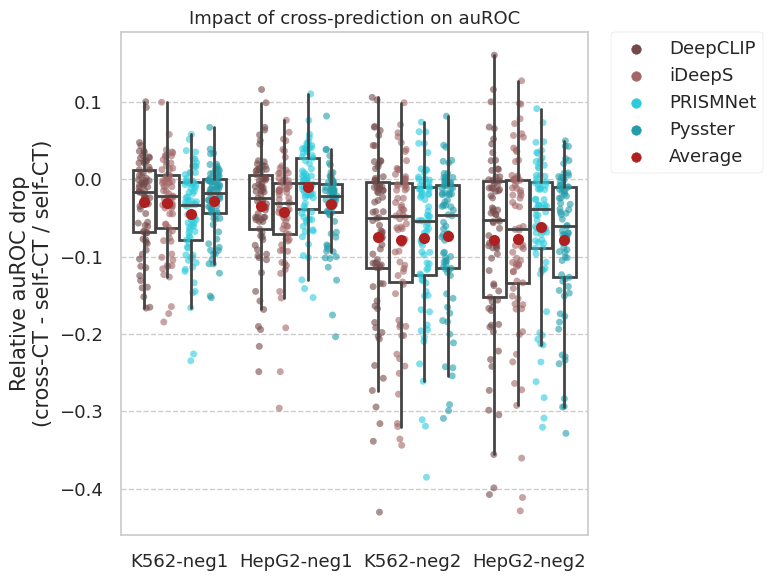

In [51]:
panel_name = "j"

figure_name = "self_vs_cross_ct_aurocs.relative_drops_boxplots"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)

BOXPLOT_PROPS = {
    "boxprops": {"facecolor": "none", "edgecolor": "#444444"},
    "medianprops": {"color": "#444444"},
    "whiskerprops": {"color": "#444444"},
    "capprops": {"color": "none"},
    "meanprops": {
        "marker": "o",
        "markerfacecolor": "#AF2121",
        "markeredgecolor": "#AF2121",
        "markersize": 8,
    },
}

sns.boxplot(
    data=reldrop_data,
    x="modelsource",
    y="auroc.reldrop",
    hue="arch",
    # inner=None,
    palette=arch_colors,
    linewidth=2,
    ax=ax1,
    showmeans=True,
    showfliers=False,
    zorder=50,
    **BOXPLOT_PROPS
)

# Remove facecolor of boxplot/violins, by using the alpha parameter
for path in ax1.collections:
    path.set_facecolor(
        "#FFFFFF00",
    )

sns.stripplot(
    data=reldrop_data,
    x="modelsource",
    y="auroc.reldrop",
    hue="arch",
    dodge=True,
    jitter=0.2,
    palette=arch_colors,
    alpha=0.6,
    zorder=1,
    ax=ax1,
)

ax1.set_ylabel("Relative auROC drop\n(cross-CT - self-CT / self-CT)")
ax1.set_xlabel("")

title = "Impact of cross-prediction on auROC"
ax1.set_title(title)


h, l = ax1.get_legend_handles_labels()
h, l = h[len(h) // 2 :], l[len(l) // 2 :],
# Add average.
avg = copy.copy(h[-1])
avg.set_color("#AF2121")
h.append(avg)
l.append("Average")
ax1.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)

plt.tight_layout()


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)


plt.show()


## Heatmap

Here the goal is to visualize whether some RBPs are more sensitive than others.

To do so: 

- heatmap of the ranked delta auROCs? (i.e. color = rank)
- displayed values should be the delta auROCs?

=> might be confusing.

Alternative:

- Order by average delta-auROCs
- Color cells by delta auROCs


Metric: Kendall's tau or Spearman rho.


## Tests

TODO:
- confirm overall difference, notably between neg-1 and neg-2 => Mann Withney Wilcoxon test.
- paired rank test to assess whether the ranks change or not => Wilcoxon Signed ranks test. (along with the heatmap viz: can we say whether e.g. the most affected RBPs are the same? i.e. the test will appear non-sign if the delta-auROCs lead to similar ranks).
- analysis of variance?


### Are K562-neg1 vs HepG2-neg1 different?

### Are K562-neg1 vs K562-neg2 different?

### Is there any method that is more robust than others?

### Other

In [122]:
# Kendall tau.
reldrop_data.assign(
    model_source_arch=lambda df: df["modelsource"] + "_" + df["arch"]
).pivot_table(
    index="RBP_dataset.self", columns="model_source_arch", values="auroc.reldrop"
).corr(
    "kendall"
)


model_source_arch,HepG2-neg1_DeepCLIP,HepG2-neg1_Pysster,HepG2-neg1_iDeepS,HepG2-neg2_DeepCLIP,HepG2-neg2_Pysster,HepG2-neg2_iDeepS,K562-neg1_DeepCLIP,K562-neg1_Pysster,K562-neg1_iDeepS,K562-neg2_DeepCLIP,K562-neg2_Pysster,K562-neg2_iDeepS
model_source_arch,,,,,,,,,,,,
HepG2-neg1_DeepCLIP,1.000000,0.659817,0.775495,0.436834,0.328006,0.419330,NaN,NaN,NaN,NaN,NaN,NaN
HepG2-neg1_Pysster,0.659817,1.000000,0.761035,0.446728,0.461187,0.459665,NaN,NaN,NaN,NaN,NaN,NaN
HepG2-neg1_iDeepS,0.775495,0.761035,1.000000,0.506088,0.420091,0.514460,NaN,NaN,NaN,NaN,NaN,NaN
HepG2-neg2_DeepCLIP,0.436834,0.446728,0.506088,1.000000,0.708524,0.837900,NaN,NaN,NaN,NaN,NaN,NaN
HepG2-neg2_Pysster,0.328006,0.461187,0.420091,0.708524,1.000000,0.722983,NaN,NaN,NaN,NaN,NaN,NaN
HepG2-neg2_iDeepS,0.419330,0.459665,0.514460,0.837900,0.722983,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
K562-neg1_DeepCLIP,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.787671,0.815068,0.635464,0.590563,0.617960
K562-neg1_Pysster,NaN,NaN,NaN,NaN,NaN,NaN,0.787671,1.000000,0.762557,0.557078,0.544140,0.548706
K562-neg1_iDeepS,NaN,NaN,NaN,NaN,NaN,NaN,0.815068,0.762557,1.000000,0.587519,0.536530,0.592846


From Kendall tau:

- values between methods on negative-1 or between methods on negative-2 are higher than values between negative-1 and negative-2
- This suggests that within a negative scheme, the different methods lead to models that have similar impact on performance depending on the RBP.
- across negative scheme this is less true (tau values are lower, e.g. `0.461187` for `HepG2-Pysster` negative-1 vs negative-2)